# Classification Data Preparation
**Traprock KBA, QLD - Change Detection Jul 2015 to Jul 2023**


Author: Michael Dear, May 2024

This notebook adds classification variables to the dataset.

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [2]:
from global_params import *

# Random state for reproducibility
random_state = 11

y_var = ['class_num']

## Step 1: Load data

In [3]:
ds = xr.load_dataset(netcdf_dir+study_area_abbrev+'.nc')

In [4]:
mask = xr.load_dataarray(netcdf_dir+'mask.nc')

In [5]:
# Load the polygon
poly = gpd.read_file(vector_dir+study_area_abbrev+'.geojson')

# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [6]:
# Put the period names in a list for convenience.
periods = list(ds.period.values)
periods

['Dec 2014', 'Dec 2023']

## Step 2: Kmeans Classification 

#### Imports

In [112]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

#### Select the variables to use in the classification

In [113]:
list(ds.data_vars.keys())

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'RF_Class',
 'NDVI_Class']

In [114]:
km_vars = [list(ds.data_vars.keys())[i] for i in [0,2,3,4]]
km_vars

['nbart_red', 'nbart_green', 'nbart_nir', 'nbart_swir_1']

#### Create the training sets

In [115]:
gdfs = [[],[]]

for i in [0,1]:
    # Convert the data array to a data frame
    df = ds.isel(period=i).to_dataframe().reset_index()
    
    # Convert to a GeoDataFrame
    gdfs[i] = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y)).set_crs(crs)

In [116]:
dfs = [ds.sel(period=period).to_dataframe().reset_index().drop(['x','y'], axis=1)[km_vars] for period in periods]

In [117]:
for i in [0,1]:
    print('Period:', i)
    print(dfs[i].head())
    print('--------------')

Period: 0
   nbart_red  nbart_green  nbart_nir  nbart_swir_1
0      993.0        792.0     2330.0        3494.0
1      930.0        746.0     2191.0        3350.0
2      841.0        669.0     2078.0        2937.0
3      975.0        791.0     2283.0        2902.0
4      795.0        637.0     2017.0        2629.0
--------------
Period: 1
   nbart_red  nbart_green  nbart_nir  nbart_swir_1
0      997.0        812.0     2508.0        3610.0
1      891.0        720.0     2247.0        3236.0
2      753.0        605.0     1963.0        2656.0
3      844.0        709.0     2081.0        2680.0
4      731.0        617.0     1881.0        2439.0
--------------


#### Standardise the training data

In [118]:
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()

for df in dfs:
    x = df.values # returns a numpy array
    x_stand = scaler.fit_transform(x)
    df[km_vars] = x_stand
    print(df.head())

   nbart_red  nbart_green  nbart_nir  nbart_swir_1
0   0.358219     0.291134   0.243100      0.994093
1   0.131642     0.076956  -0.076423      0.784053
2  -0.188443    -0.281560  -0.336179      0.181647
3   0.293483     0.286478   0.135060      0.130595
4  -0.353881    -0.430554  -0.476402     -0.267605
   nbart_red  nbart_green  nbart_nir  nbart_swir_1
0   0.056022     0.081579   0.290537      0.782469
1  -0.273891    -0.287174  -0.208384      0.310607
2  -0.703399    -0.748116  -0.751271     -0.421158
3  -0.420173    -0.331264  -0.525706     -0.390878
4  -0.771872    -0.700017  -0.908020     -0.694938


#### Apply Kmeans

In [119]:
ks = np.arange(2,8)

# Set random_state for reproducibility
kms = [KMeans(n_clusters=k, random_state = random_state) for k in ks]

In [120]:
# Sizes for reshaping flattened arrays
w = ds.sizes['y']
l = ds.sizes['x']

#### Fit on all data for each period and each k

In [121]:
%%time
km_fit = [[km.fit(df).labels_.reshape(w,l) for df in dfs] for km in kms]

#### Plot

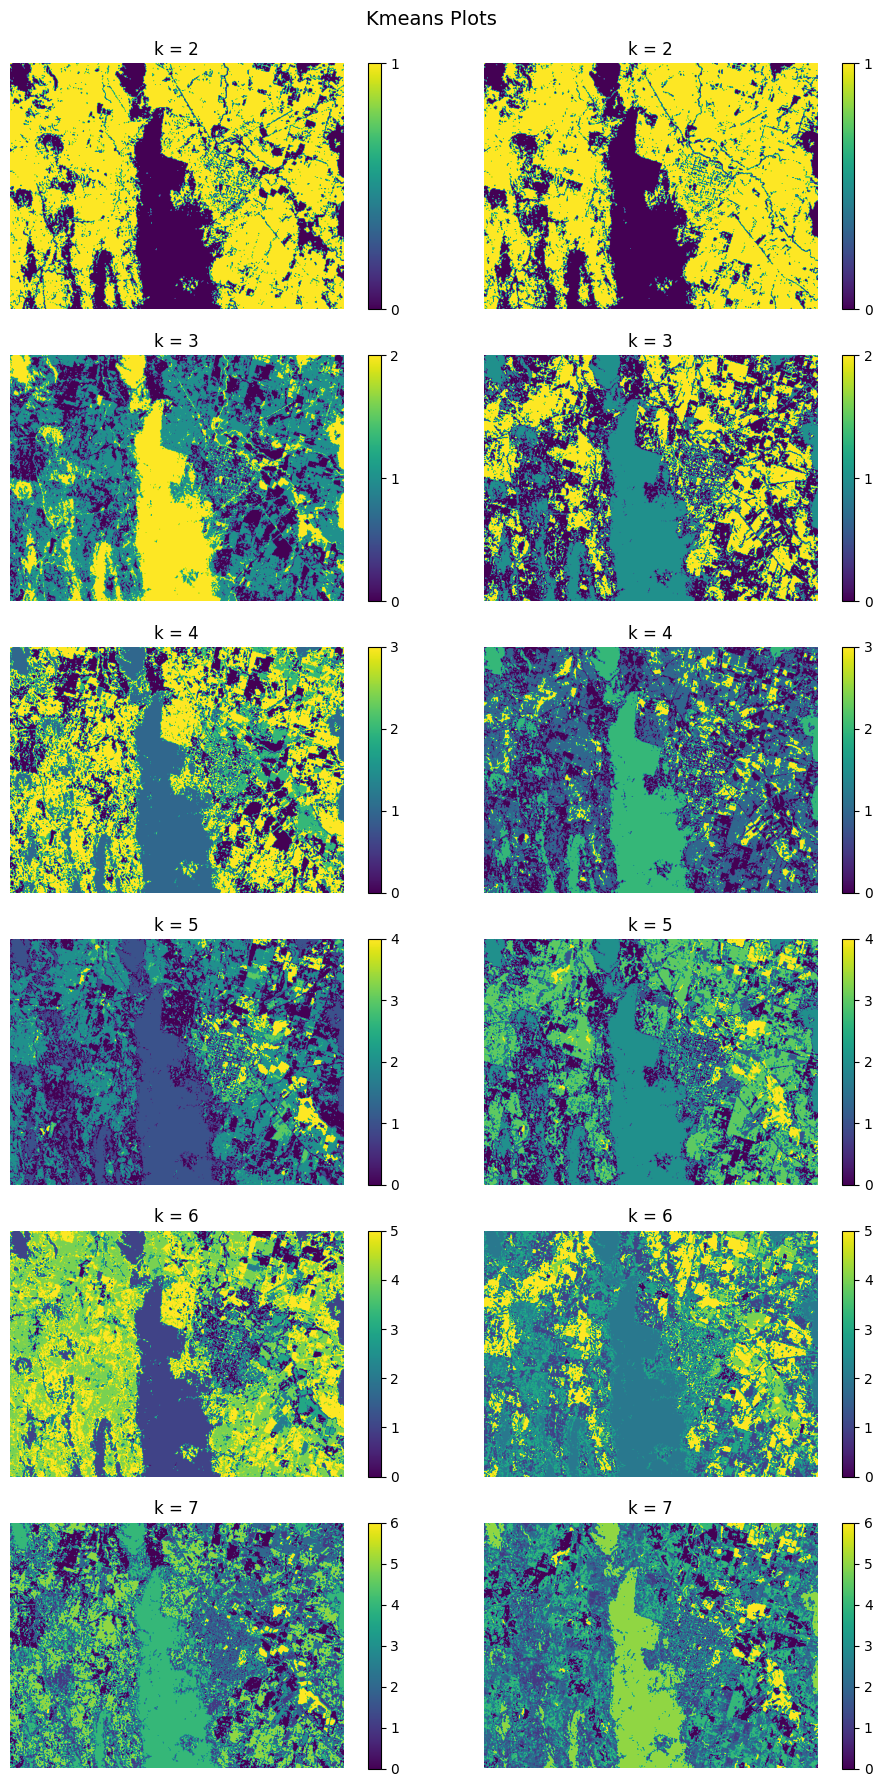

In [122]:
nrow=len(ks)
ncol=2

fig, axes = plt.subplots(nrow, ncol, figsize=(10, nrow*3))

for row in np.arange(nrow):
    for col in np.arange(ncol):
        cl_nums = np.unique(km_fit[row][col])
        ax = axes[row,col]
        color = ax.imshow(km_fit[row][col])
        ax.axis('off')
        ax.set_title('k = '+str(len(cl_nums)))
        cb = plt.colorbar(color)
        cb.set_ticks(cl_nums)

fig.suptitle('Kmeans Plots', y=0.99, fontsize=14);

fig.tight_layout()

fig.savefig(img_dir+'Kmeans_plots_'+periods[0]+'-'+periods[1]+'.png', dpi=600, bbox_inches = "tight");

plt.show()
plt.close('all')

#### Add the classification data to the dataset

In [124]:
km_best=[km_fit[3][0], km_fit[3][1]]

In [125]:
# Convert to int16
km_arrs = np.array(km_best, dtype=np.int16)

In [126]:
ds = ds.assign({'Kmeans_Class': (('period','y','x'), km_arrs)})

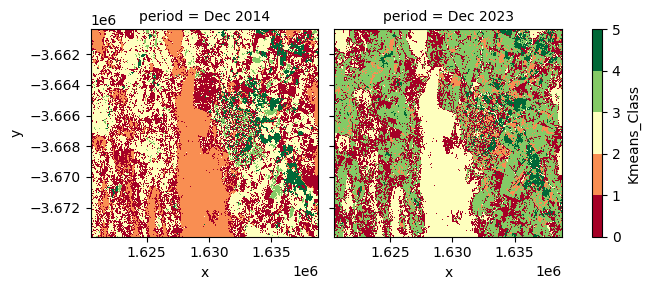

In [127]:
ds.Kmeans_Class.plot(col='period', 
                     levels=np.arange(len(np.unique(ds.Kmeans_Class))+1),
                     cmap='RdYlGn')

#### Re-code Classes (Optional)


In [134]:
old_vals = np.array(km_arrs)

In [135]:
new_vals = np.empty(old_vals.shape)
new_vals.shape

(2, 450, 610)

In [136]:
# Use the same re-code values for both periods if using Option 1.
recode = (
    [(0,2),(1,3),(2,1),(3,0),(4,4)],
    [(0,2),(1,0),(2,3),(3,1),(4,4)]
)

In [137]:
for i in [0,1]:
    for j in np.arange(len(np.unique(old_vals[i]))):
        new_vals[i][old_vals[i]==recode[i][j][0]] = recode[i][j][1]

In [138]:
ds.Kmeans_Class.values = new_vals

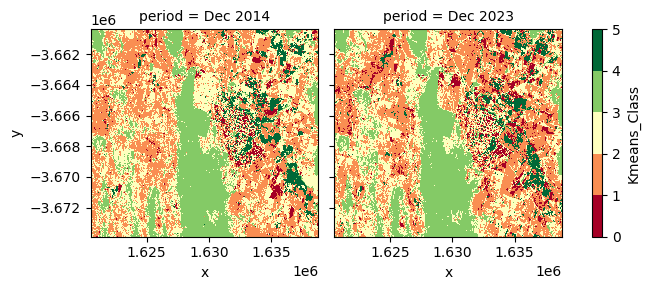

In [139]:
ds.Kmeans_Class.plot(col='period', 
                     levels=np.arange(len(np.unique(ds.Kmeans_Class))+1),
                     cmap='RdYlGn')

## Step 3: Ground-truth Points (GTP)
The process is:
1. Create polygons for each class using QGIS, Google Earth, and composite plots for each period.
2. Intersect the polygons with the data array to create a candidate set of points for each period.
3. Reduce the candidate set in each class to the size of the smallest class.
4. Train the classifier.
5. Predict.

See https://stackoverflow.com/questions/65504116/how-to-convert-a-xarray-dataarray-to-a-geopandas-geodataframe for converting a data array to points.

In [33]:
# Read in the labelled polygons
gtp_polys = [gpd.read_file(vector_dir+'gtp_polygons_'+str(i)+'_reduced.geojson').to_crs(crs) for i in [0,1]]

-----
#### (Optional) Apply internal buffer

In [8]:
# Apply internal buffer if required
for i in [0,1]:
    gtp_polys[i]['geometry'] = gtp_polys[i].buffer(-10)

------

In [9]:
for i in [0,1]:
    print(gtp_polys[i].head())

   class_num     class_name                                           geometry
0          1           Bare  MULTIPOLYGON (((1635539.142 -3669339.062, 1635...
1          2      Developed  MULTIPOLYGON (((1635738.946 -3663114.442, 1635...
2          3          Grass  MULTIPOLYGON (((1629989.431 -3664151.843, 1630...
3          4  Medium Wooded  MULTIPOLYGON (((1631706.313 -3670216.866, 1631...
4          5   Dense Wooded  MULTIPOLYGON (((1629887.604 -3669745.109, 1630...
   class_num     class_name                                           geometry
0          1           Bare  MULTIPOLYGON (((1633948.978 -3669172.733, 1634...
1          2      Developed  MULTIPOLYGON (((1635738.946 -3663114.442, 1635...
2          3          Grass  MULTIPOLYGON (((1629989.431 -3664151.843, 1630...
3          4  Medium Wooded  MULTIPOLYGON (((1631706.313 -3670216.866, 1631...
4          5   Dense Wooded  MULTIPOLYGON (((1629887.604 -3669745.109, 1630...


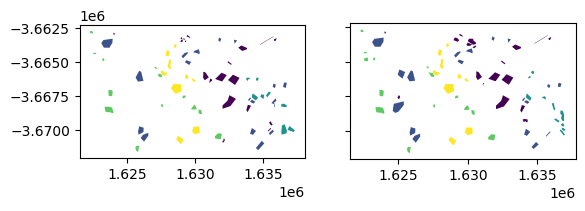

In [34]:
# Plot to check the data
fig, axes = plt.subplots(1,2, sharey=True)
for i in [0,1]:
    unq_nums = np.unique(gtp_polys[i]['class_num'])
    gtp_polys[i].plot(ax=axes[i], column='class_num')

In [35]:
X_vars = list(ds.data_vars.keys())[:8]
X_vars

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR']

In [36]:
gtp_base = [[],[]]
thold_var = ''

for i in [0,1]:
    # Convert the data array to a data frame
    df = ds.isel(period=i).to_dataframe().reset_index()
    
    # Convert to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y)).set_crs(crs)

    # Make a bare/water class using NDVI threshold
    if thold_var!='':
        bare = gdf[gdf[thold_var]<= -0.025]
        bare['class_num'] = 0
        bare['class_name'] = 'Water'
    
    # Intersect the points with the polygons
    gdf = gpd.sjoin(gdf, gtp_polys[i], how='inner') # Limit to polygon

    if thold_var!='':
        gtp_base[i] = pd.concat([gdf[X_vars+['class_num','class_name','geometry']], bare[X_vars+['class_num','class_name','geometry']]], axis=0)
    else:
        gtp_base[i] = gdf[X_vars+['class_num','class_name','geometry']]

    gtp_base[i]['class_num'] = gtp_base[i]['class_num'].astype(np.int16)

In [16]:
for i in [0,1]:
    print('Period:', i)
    print(gtp_base[i].head())
    print('--------------')

Period: 0
       nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
49526     1523.0       818.0       1174.0     2756.0        4297.0   
50137     1746.0       986.0       1340.0     2784.0        4363.0   
50138     1672.0       954.0       1291.0     2672.0        4204.0   
50139     1624.0       910.0       1262.0     2629.0        4037.0   
50747     1729.0      1003.0       1332.0     2745.0        4320.0   

       nbart_swir_2      NDVI       NBR  class_num class_name  \
49526        3275.0  0.288151 -0.086055          1       Bare   
50137        3574.0  0.229139 -0.124253          1       Bare   
50138        3391.0  0.230203 -0.118588          1       Bare   
50139        3142.0  0.236304 -0.088893          1       Bare   
50747        3512.0  0.227090 -0.122583          1       Bare   

                               geometry  
49526  POINT (1624005.000 -3662835.000)  
50137  POINT (1624035.000 -3662865.000)  
50138  POINT (1624065.000 -3662865.000)  
50139  POI

#### Count the number of points in each class

In [37]:
# Count the number of points in each class
for i in [0,1]:
    print('Period:', i)
    print(gtp_base[i]['class_num'].value_counts())
    print('--------------')


Period: 0
class_num
1    2232
0    1915
4    1443
3    1081
2     833
Name: count, dtype: int64
--------------
Period: 1
class_num
1    2714
0    2177
4    1443
3    1174
2     646
Name: count, dtype: int64
--------------


#### (Optional) Combine classes

In [104]:
for i in [0,1]:
    print(periods[i])
    print('============')
    print(gtp_base[i]['class_num'].unique())
    print(gtp_base[i]['class_name'].unique())
    print('--------------')

Dec 2014
[0 1 6 2 4 3 5]
['Bare' 'Developed' 'Brown Crops' 'Grass' 'Dense Wooded' 'Medium Wooded'
 'Green Crops']
--------------
Dec 2023
[0 1 6 2 4 3 5]
['Bare' 'Developed' 'Brown Crops' 'Grass' 'Dense Wooded' 'Medium Wooded'
 'Green Crops']
--------------


In [125]:
for i in [0,1]:
    gtp_base[i]['class_num'][gtp_base[i]['class_num']==0] = 1
    gtp_base[i]['class_name'][gtp_base[i]['class_name']=='Water'] = 'Bare'
    gtp_base[i]['class_num'] = gtp_base[i]['class_num'] - 1

#### Reduce each class to the size of the smallest class

In [38]:
# Reduce each class to the size of the smallest class
sample_size = np.min([gtp_base[i]['class_num'].value_counts().min() for i in [0,1]])

gtp_equal = [pd.concat([gtp_base[i][gtp_base[i]['class_num']==cl].sample(sample_size, random_state=random_state) 
                for cl in gtp_base[i]['class_num'].unique()], axis=0) 
                for i in [0,1]]

In [17]:
# Count the number of points in each class
for i in [0,1]:
    print(periods[i])
    print('============')
    print(gtp_equal[i]['class_num'].value_counts())
    print('--------------')


Dec 2014
class_num
0    607
1    607
4    607
3    607
2    607
Name: count, dtype: int64
--------------
Dec 2023
class_num
0    607
1    607
4    607
3    607
2    607
Name: count, dtype: int64
--------------


## Step 4: Random Forest
Based on
* https://www.datacamp.com/tutorial/random-forests-classifier-python
* https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial

#### Imports

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#### Create the training and test sets

In [19]:
list(ds.data_vars.keys())

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'RF_Class']

In [20]:
rf_vars = [list(ds.data_vars.keys())[i] for i in np.arange(8)]
rf_vars

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR']

In [39]:
X = [gdf[rf_vars] for gdf in gtp_equal]
y = [gdf[y_var] for gdf in gtp_equal]

In [40]:
# Need to use `stratify` to get the same number of samples in each class
# https://stackoverflow.com/a/29477256/8299958
gtp_tt = [train_test_split(X[i], y[i], test_size=0.2, stratify=y[i], random_state=random_state) for i in [0,1]]

In [41]:
pd.DataFrame([[int(len(gtp_tt[i][0])/len(cl_labels)),int(len(gtp_tt[i][1])/len(cl_labels))] for i in [0,1]],
            columns=['Train', 'Test'],
            index=periods)

,Train,Test
Dec 2014,516,129
Dec 2023,516,129


In [23]:
for i in [0,1]:
    print(gtp_tt[i][0][:5])
    print(gtp_tt[i][2][:5])

        nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
80588       594.0       346.0        509.0     1969.0        2301.0   
155386     1350.0      1119.0       1316.0     2083.0        1796.0   
91036       881.0       475.0        906.0      656.0        1195.0   
61893      1775.0      1027.0       1402.0     2369.0        2530.0   
64140       784.0       416.0        662.0     1959.0        2815.0   

        nbart_swir_2      NDVI       NBR  
80588         1238.0  0.536481  0.227939  
155386        1600.0  0.213516  0.131143  
91036          818.0 -0.146389 -0.109905  
61893         2009.0  0.143340  0.082229  
64140         1879.0  0.428363  0.020844  
        class_num
80588           4
155386          2
91036           0
61893           1
64140           3
        nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
80588       550.0       347.0        524.0     2039.0        2029.0   
155386     1574.0      1210.0       1635.0     2267.0        2352

#### Basic RF

In [42]:
%%time

# List to hold the trained classifiers
rfs = []
# List to hold the accuracies
acc = []
# List to hold the precision and recall data frames
pre_rec = []
# List to hold the confusion matrix data frames
cm = []
# List to hold the feature scores
feat_scores = []


for i in [0,1]:
    # Create and fit the RF classifier
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(gtp_tt[i][0], gtp_tt[i][2])

    # Append model to list
    rfs.append(rf)
    
    # Predict
    y_pred = rf.predict(gtp_tt[i][1])

    # Assess accuracy, precision, recall
    acc.append(accuracy_score(gtp_tt[i][3], y_pred))
    pre_rec.append(pd.DataFrame({'Precision': precision_score(gtp_tt[i][3], y_pred, average=None),
                               'Recall': recall_score(gtp_tt[i][3], y_pred, average=None)
                              },
                               index=cl_labels)
                  )
    
    print(periods[i])
    print('============')
    print('Accuracy =', acc[i])
    print()
    print('Precision and Recall')
    print(pre_rec[i])
    print()
    
    # List the importance of features
    print('Feature Importance')
    feat_scores.append(pd.DataFrame({'Importance':rf.feature_importances_}, index=gtp_tt[i][0].columns))
    print(feat_scores[i])
    print()

    # Confusion matrix
    cm.append(pd.DataFrame(confusion_matrix(gtp_tt[i][3], y_pred),
                           columns = cl_labels,
                                  index=cl_labels
                          )
             )
    print('Confusion matrix')
    print(cm[i])
    print()

Dec 2014
Accuracy = 0.9659442724458205

Precision and Recall
               Precision    Recall
Non-veg         0.984496  0.984496
Brown Veg       0.984615  0.984615
Green Veg       0.992308  1.000000
Medium Wooded   0.944000  0.914729
Dense Wooded    0.924242  0.945736

Feature Importance
              Importance
nbart_red       0.124500
nbart_blue      0.161685
nbart_green     0.152688
nbart_nir       0.067149
nbart_swir_1    0.123681
nbart_swir_2    0.111779
NDVI            0.136595
NBR             0.121923

Confusion matrix
               Non-veg  Brown Veg  Green Veg  Medium Wooded  Dense Wooded
Non-veg            127          1          1              0             0
Brown Veg            2        128          0              0             0
Green Veg            0          0        129              0             0
Medium Wooded        0          1          0            118            10
Dense Wooded         0          0          0              7           122

Dec 2023
Accuracy = 0

In [43]:
# For copying to the report
cm[0]
# cm[1]

,Non-veg,Brown Veg,Green Veg,Medium Wooded,Dense Wooded
Non-veg,127,1,1,0,0
Brown Veg,2,128,0,0,0
Green Veg,0,0,129,0,0
Medium Wooded,0,1,0,118,10
Dense Wooded,0,0,0,7,122


#### RF With Hyperparameter Tuning
*Warning*: This will take a long time to complete.

In [488]:
%%time

# List to hold the trained classifiers
rfs = []

for i in [0,1]:
    # Create the parameter grid
    param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

    # Create a random forest classifier
    rf = RandomForestClassifier(random_state=random_state)
    
    # Use random search to find the best hyperparameters
    rand_search = RandomizedSearchCV(rf, 
                                     param_distributions = param_dist, 
                                     n_iter=5, 
                                     cv=5)

    # Split the data into training and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.2, random_state=random_state)
   
    # Fit the random_search to the data
    rand_search.fit(gtp_tt[i][0], gtp_tt[i][2])

    # Store the best model
    best_rf = rand_search.best_estimator_

    # Predict
    y_pred = best_rf.predict(gtp_tt[i][1])
    accuracy = accuracy_score(gtp_tt[i][3], y_pred)

    # Append best model to list
    rfs.append(best_rf)

    print(periods[i])
    print('============')
    # print('y_test:', y_test['class'].values)
    # print('y_pred:', y_pred)
    print("Accuracy:", accuracy)
    print()

    # List the importance of features
    print('Feature Importance')
    feature_scores = pd.Series(best_rf.feature_importances_, index=gtp_tt[i][0].columns).sort_values(ascending=False)
    print(feature_scores)
    print()

    # Confusion matrix
    cm = confusion_matrix(gtp_tt[i][3], y_pred)
    print('Confusion matrix')
    print(cm)
    print()

Jul 2015
Accuracy: 0.938006723353767

Feature Importance
nbart_swir_2    0.245012
nbart_red       0.238164
nbart_swir_1    0.156639
nbart_green     0.133209
NDVI            0.118846
nbart_blue      0.075049
nbart_nir       0.033079
dtype: float64

Confusion matrix
[[  88    4   79    3]
 [   0  304  244    2]
 [  10   84 2573  133]
 [   0    0   68 6522]]



KeyboardInterrupt: 

#### Predictions for each period

In [44]:
rf_arrs = [[] for i in [0,1]]

In [45]:
# Sizes for reshaping flattened arrays
w = ds.sizes['y']
l = ds.sizes['x']

In [46]:
%%time
rf_arrs = [rfs[i].predict(ds.sel(period=periods[i]).to_dataframe()[rf_vars].values).reshape(w,l) for i, period in enumerate(periods)]

CPU times: total: 3.88 s
Wall time: 4.1 s


#### Add the classification data to the dataset

In [47]:
ds = ds.assign({'RF_Class': (('period','y','x'), rf_arrs)})

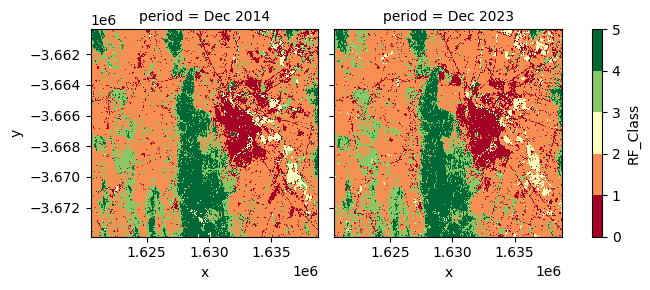

In [48]:
ds.RF_Class.plot(col='period', 
                 levels=np.arange(len(np.unique(ds.RF_Class))+1),
                 cmap='RdYlGn')

## Step 4: Export data 

### netCDF

In [140]:
# Save as netCDF
ds.to_netcdf(netcdf_dir+study_area_abbrev+'.nc')

### GeoTIFF - Time steps

Each year is saved with all variables in a geoTIFF file.

**Note**: Converting `to_array()` is essential to avoid "ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''" error.  


In [141]:
for period in ds.period.values:
     (ds
     .sel(period=period)
     .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'.tiff')
     )

In [ ]:
# Single variable
class_var = 'RF_Class'
for period in ds.period.values:
     (ds[class_var]
     .sel(period=period)
     # .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'_'+class_var+'.tiff')
     )

---------

In [142]:
ds

<xarray.Dataset>
Dimensions:       (period: 2, y: 450, x: 610)
Coordinates:
  * y             (y) float64 -3.66e+06 -3.66e+06 ... -3.674e+06 -3.674e+06
  * x             (x) float64 1.621e+06 1.621e+06 ... 1.639e+06 1.639e+06
    spatial_ref   int32 3577
  * period        (period) <U8 'Dec 2014' 'Dec 2023'
Data variables:
    nbart_red     (period, y, x) float32 993.0 930.0 ... 1.328e+03 1.291e+03
    nbart_blue    (period, y, x) float32 526.0 502.0 460.0 ... 709.0 738.0 717.0
    nbart_green   (period, y, x) float32 792.0 746.0 ... 1.03e+03 1.009e+03
    nbart_nir     (period, y, x) float32 2.33e+03 2.191e+03 ... 2.68e+03
    nbart_swir_1  (period, y, x) float32 3.494e+03 3.35e+03 ... 4.025e+03
    nbart_swir_2  (period, y, x) float32 2.224e+03 2.148e+03 ... 2.729e+03
    NDVI          (period, y, x) float32 0.4023 0.404 0.4238 ... 0.3516 0.3498
    NBR           (period, y, x) float32 0.02328 0.00991 ... 0.003808 -0.009059
    RF_Class      (period, y, x) int16 1 1 3 1 3 3 3 4 4 3 ... 1 1 1 1 1 0 1 1 1
    NDVI_Class    (period, y, x) int16 2 2 2 2 2 2 2 3 3 3 ... 1 1 1 1 1 1 1 1 1
    Kmeans_Class  (period, y, x) float64 1.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0